# Sprint21課題 セグメンテーション2

## 1.この課題の目的

- セグメンテーションの精度を改善する

In [1]:
import gc
import glob
import os, sys

import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras import backend as K
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
path = '/content/gdrive/My Drive/My Documents/Study/Programming/DIVE INTO CODE/Class/sprint21'

In [0]:
os.chdir(path)

In [5]:
!ls -1

03-models_pretrained_and_more.ipynb
clean-workflow-in-keras.ipynb
sample_submission.csv
sample_submission.gsheet
sprint21-segmentation2.ipynb
test
train
train.gsheet
unet_resnet.h5
unet_vgg.h5


## 2.セグメンテーションの精度向上

前回に引き続きTGS Salt Identification Challengeのデータセットの学習・推定を行う。

[TGS Salt Identification Challenge | Kaggle](https://www.kaggle.com/c/tgs-salt-identification-challenge)

### 【問題1】コードレビュー
転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行うこと。

- 視点例
  - Sprint20で使用した実装とはどのように違うのか
  - 転移学習をどのように行っているか

#### レビューする項目（U-Netと今回のモデル（ResNetベース）を比較）：<font color="firebrick">**なぜ精度が改善するのか？学習時間は短くなるのか？**</font>。

1. アーキテクチャー(Summaryは以下の通り)
  - レイヤーの数 ：今回のモデルは5層、U-Netは14層
  - concatenate(cropping) : 両モデルで実施
  - Dropout : 両モデルで実施
  - BatchNormalization : 今回のモデルのみ実施
  
2. 重みの初期値

3. 活性化関数

4. 損失関数

5. 最適化手法

6. 評価手法

7. 学習時間

8. 入力サイズ

9. 出力サイズ

### レビュー結果

**1. アーキテクチャー**

- レイヤーの構造
  - 今回のモデル：<font color="blue">ResNet50</font>をベースに構築（**unet_resnet()メソッド**で定義）
    - Down-sampling（encoding）：
      - ５層：paddingが"same"ではないので、層が深くになるにつれてoutput_sizeが縮小する
        1. activation_1', shape: (None, 112, 112, 64)
        2. 'activation_10', shape: (None, 56, 56, 256)
        3. 'activation_22', shape: (None, 28, 28, 512)
        4. 'activation_40', shape: (None, 14, 14, 1024)
        5. 'activation_49', shape: (None, 7, 7, 2048)
      
    - Up-sampling（de-coding）
      - 5層:
        1. center_conv: (7, 7, 512)
        2. decoder4_conv : (7, 7, 256)
        3. decoder3_conv : (14, 14, 128)
        4. decoder2_conv : (28, 28, 64)
        5. decoder1_conv : (56, 56, 64)
  
  - U-Net：
    - Down-sampling：いずれのconvolution layerでもpaddingを"same"としており、output_sizeは不変。
      - 14層：dropoutレイヤーを除く。
        1. conv1 : (64, 64, 3)
        2. conv1 : (64, 64, 3)
        3. pool1 : (2,2)
        4. conv2 : (128, 128, 3)
        5. conv2 : (128, 128, 3)
        6. pool2 : (2,2)
        7. conv3 : (256, 256, 3)
        8. conv3 : (256, 256, 3)
        9. pool3 : (2,2)
        10. conv4 : (512, 512, 3)
        11. conv4 : (512, 512, 3)
        12. pool4 : (2,2)
        13. conv5 : (1024, 1024, 3)
        14. conv5 : (1024, 1024, 3)
    
    - Up-sampling：
      - 14層：mergeレイヤー（concatenat）を除く。
        1. up6 : (512, 512, 2)
        2. conv6 : (512, 512, 3)
        3. conv6 : (512, 512, 3)
        4. up7 : (256, 256, 2)
        5. conv7 : (256, 256, 3)
        6. conv7 : (256, 256, 3)
        7. up8 : (128, 128, 2)
        8. conv8 : (128, 128, 3)
        9. conv8 : (128, 128, 3)
        10. up9 : (64, 64, 2)
        11. conv9 : (64, 3)
        12. conv9 : (64, 3)
        13. conv9 : (2, 3)
        14. conv10 : (1, 1)
    
  - concatenate（cropping）
    - 今回のモデル：実施
    - U-Net：実施

  - dropout : 
    - 今回のモデル : Up-samplingで実施
    - U-Net：Down-samplingで実施
    
  - batch_normalization:
    - 今回のモデル：あり
    - U-Net：なし

<br>

**2. 重み**
  - 今回のモデル：
    - **ImageNet**で学習した重みをpretrained_weightsとして使用している。
    - 転移学習は、ハイパーパラメータinclude_topを<font color="blue">False</font>にすることで実行している。
    
    
  - U-Net：
    - デフォルトはhe_initializer（標準偏差$√2/N$のガウス分布：Nは"ノード数"）で初期化。論文のとお理。
    - pretrained_weightsを用いることも可能（model.load_weights(pretrained_weights)で実装済）

<br>

**3. 活性化関数**
  - 今回のモデル：PReLU（Parametric Recitied Linear Unit）定義は以下の通り。（入力値$y$が負の場合でも調整可能）
    - ${f(y_i)=
\left\{
\begin{array}{l}
y_i,\,if\,y_i > 0.\\
a_i y_i,\,if\,y_i \leq 0
\end{array}
\right.
}$
  - U-Net：ReLU

<br>

**4.  損失関数**
  - 今回のモデル：binary_crossentropy
  - U-Net：binary_crossentropy

<br>

**5. 最適化手法**
  - 今回のモデル：Adam
  - U-Net：Adam

<br>

**6. 評価手法（metrics）**
  - 今回のモデル：IoU(Intersection over Union) => **my_iou_metrics()**メソッドで算出(デフォルトの閾値は0.5)
  - U-Net : accuracy

<br>

**7. 学習の所要時間（1 epochあたり）**
  - 今回のモデル：120s（早い）
  - U-Net：30分
  
<br>
  
**8. Input_size**
  - 今回のモデル：(224, 224, 3)
  - U-Net：(256, 256,)
 
<br>
  
**9. Output_size**
  - 今回のモデル : (224, 224, 1)
  - U-Net : (256, 256)

### 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更する。

In [0]:
os.chdir(path)

In [7]:
os.getcwd()

'/content/gdrive/My Drive/My Documents/Study/Programming/DIVE INTO CODE/Class/sprint21'

### KerasにおけるResNet、及びVGG19のアーキテクチャを確認する

In [8]:
ResNet = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

W0722 09:45:51.238222 140253591431040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 09:45:51.273955 140253591431040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 09:45:51.284474 140253591431040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0722 09:45:51.318866 140253591431040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 09:45:51.319768

102858752/102853048 [==============================] - 1s 0us/step


In [9]:
ResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
VGG = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

574717952/574710816 [==============================] - 6s 0us/step


In [11]:
VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

- ResNetからVGGへのコード変更では、ResNetとVGG19でそれぞれ既定されているアーキテクチャ、layer_nameを参照する必要がある。

### Data loading & depth merge

In [0]:
from keras.losses import binary_crossentropy

# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [0]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(
        layer_name, block_name,
        num_filters=32,
        conv_dim=(3, 3),
        dropout_frac=0.2):

    x_dec = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(
        name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(
        name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(
        num_filters // 2, conv_dim,
        padding='same',
        name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(
        name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(
        num_filters, conv_dim,
        padding='same',
        name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(
        name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(
        name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### ResNet：ResNetを応用したU-Netモデルのコードサンプルは以下の通り。

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.

def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder - transfer_learning
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer("activation_1").output # (None, 112, 112, 64)
    encoder2 = base_model.get_layer('activation_10').output # (None, 56, 56, 256)
    encoder3 = base_model.get_layer('activation_22').output # (None, 28, 28, 512)
    encoder4 = base_model.get_layer('activation_40').output # (None, 14, 14, 1024)
    encoder5 = base_model.get_layer('activation_49').output # (None, 7, 7, 2048)
    
    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### VGG19：

ResNetを応用したU-Netのコードサンプルから以下の点を変更し、VGG19によるU-Netのコードを作成した。

1. base_modelを変更：ResNet50 => VGG19 
2. encoderのlayer nameを変更：
  - ResNet : "activation" => VGG19 : "block_conv" or "block_pool"

In [0]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder - transfer_learning
    base_model = VGG19(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('block2_conv2').output # (None, 112, 112, 128)
    encoder2 = base_model.get_layer('block3_conv4').output # (None, 56, 56, 256)
    encoder3 = base_model.get_layer('block4_conv4').output # (None, 28, 28, 512)
    encoder4 = base_model.get_layer('block5_conv4').output # (None, 14, 14, 512)
    encoder5 = base_model.get_layer('block5_pool').output # (None, 7, 7, 512)
    
    # Center block
    center = decoder_block(
        encoder5, 'center', num_filters=512)
    
    concat5 = concatenate([center, encoder5], axis=-1)
    
    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(
        concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(
        concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(
        concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(
        concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(
        output, 'decoder_output', num_filters=32)
    output = Conv2D(
        1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

#### VGG概要

- Oxford Universityの[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)の研究成果。

- アーキテクチャーは以下の通り。（D：VGG16, E：VGG19）

![VGGシリーズ](https://camo.qiitausercontent.com/1e7345bfb03076c4d56ea941798416d1e25cfb78/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3233333734342f61306538383338352d343733622d643238612d623663362d3132613233643463393135662e6a706567)

### 【問題3】学習・推定
ResNetとVGG双方のコードで学習・推定を行い、結果を比較する。

### Define SaltParser

In [0]:
class SaltParser(object):

    """
    Parser for Salt Competition.
    """

    def __init__(self,
                 data_src='./',
                 image_size=(224, 224),
                 pad_images=False,
                 grayscale=True,
                 load_test_data=True,
                 test_data_size=30):

        self.data_src = data_src
        self.image_size = image_size
        self.pad_images = pad_images
        self.grayscale = grayscale
        self.load_test_data = load_test_data

        self.train_df = None
        self.test_df = None
        self.test_data_size = test_data_size
        self.padding_pixels = None

        self.X_train = []
        self.y_train = []
        self.X_test = []

        self.orig_image_size = (101, 101)
        
        """
        # Arguments:
        
            data_src: directory containing data
            image_size: tuple specifying final image size
            pad_images: whether images should be padded or resized
            grayscale: whether to load images as grayscale
            load_test_data: whether to load test data
            
        """

    def initialize_data(self):
        
        """
        Initialize processing by loading .csv files.
        """

        train_df = pd.read_csv('{}train/train.csv'.format(self.data_src),
                               usecols=[0], index_col='id')
        depths_df = pd.read_csv('{}train/depths.csv'.format(self.data_src),
                                index_col='id')

        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    def load_data(self):
        
        """
        Load images and masks from training set.
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        """
        
        print('Loading training set.')
        # Loop over ids in train_df
        for i in tqdm(self.train_df.index):
            # Load image and mask according to ID
            img_src = '{}train/images/{}.png'.format(self.data_src, i)
            mask_src = '{}train/masks/{}.png'.format(self.data_src, i)
            
            print("img_src : {}. mask_src : {}".format(img_src, mask_src))
            
            # Specify if image should be loaded in grayscale.
            if self.grayscale:
                img_temp = cv2.imread(img_src, 0)
            else:
                img_temp = cv2.imread(img_src)
            # Load mask
            mask_temp = cv2.imread(mask_src, 0)
            # Resize or pad image and mask
            if self.orig_image_size != self.image_size:
                if self.pad_images:
                    img_temp = self.__pad_image(img_temp)
                    mask_temp = self.__pad_image(mask_temp)
                else:
                    img_temp = cv2.resize(img_temp, self.image_size)
                    mask_temp = cv2.resize(mask_temp, self.image_size)
            # Append processed image and mask
            self.X_train.append(img_temp)
            self.y_train.append(mask_temp)

        # Transform into arrays
        self.X_train = np.asarray(self.X_train)
        self.y_train = np.asarray(self.y_train)
        # If images were loaded as grayscale, they are loaded as (HxW) arrays
        # Dimensions must be expanded for the model to be trained.
        if self.grayscale:
            self.X_train = np.expand_dims(self.X_train, -1)
        # Mask must be expanded obligatorily, as they are 1-channel by default.
        self.y_train = np.expand_dims(self.y_train, -1)

        # Output information about training set.
        print('Training set ready.')
        print('X_train shape: {}'.format(self.X_train.shape))
        print('y_train shape: {}'.format(self.y_train.shape))
        print('X_train - min: {}, max: {}'.format(
            np.min(self.X_train), np.max(self.X_train)))
        print('y_train - min: {}, max: {}'.format(
            np.min(self.y_train), np.max(self.y_train)))
        
        # Load test data.
        # Perform similar steps to the training processing part,
        # but there are no masks to be loaded.
        if self.load_test_data:
            print('Loading test set.')
            for i in tqdm(range(1, self.test_data_size+1)):
                img_src = '{}test/images/{}.png'.format(self.data_src, i)
                print("img_src : ", img_src)
                if self.grayscale:
                    img_temp = cv2.imread(img_src, 0)
                    cv2.imshow("img_temp", img_temp)
                else:
                    img_temp = cv2.imread(img_src)
                if self.orig_image_size != self.image_size:
                    if self.pad_images:
                        img_temp = self.__pad_image(img_temp)
                    else:
                        img_temp = cv2.resize(img_temp, self.image_size)
                self.X_test.append(img_temp)

            self.X_test = np.asarray(self.X_test)
            if self.grayscale:
                self.X_test = np.expand_dims(self.X_test, -1)

            print('Test set ready.')
            print('X_test shape: {}'.format(self.X_test.shape))
            print('X_test - min: {}, max: {}'.format(
                np.min(self.X_test), np.max(self.X_test)))

            return self.X_train, self.y_train, self.X_test

        return self.X_train, self.y_train

    def compute_coverage(self):
        
        """
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        """

        print('Compute mask coverage for each observation.')

        def cov_to_class(val):
            for i in range(0, 11):
                if val * 10 <= i:
                    return i

        # Output percentage of area covered by class
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        # Coverage must be split into bins, otherwise stratified split will not be possible,
        # because each coverage will occur only once.
        self.train_df['coverage_class'] = self.train_df.coverage.map(
            cov_to_class)

        return self.train_df

    def predictions_rle_encode(self,
                               y_pred_test,
                               confidence_threshold_best):
        
        """
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        """

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (self.test_data_size, self.orig_image_size[0], orig_image_size[1]), '\
        Test predictions shape must be equal to (self.test_data_size, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        """
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        """

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        """
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        """
        return self.padding_pixels

    def __pad_image(self, img):
        
        """
        Helper function for images padding.
        
        # Arguments:
            img: image as np.array
            
        # Returns:
            img: padded image as np.array
        """

        pad_floor = np.floor(
            (np.asarray(self.image_size) - np.asarray(self.orig_image_size)) / 2)
        pad_ceil = np.ceil((np.asarray(self.image_size) -
                            np.asarray(self.orig_image_size)) / 2)

        self.padding_pixels = np.asarray(
            (pad_floor[0], pad_ceil[0], pad_floor[1], pad_ceil[1])).astype(np.int32)

        y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
            0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]

        img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad,
                                 x_min_pad, x_max_pad,
                                 cv2.BORDER_REFLECT_101)

        assert img.shape[:2] == self.image_size, '\
        Image after padding must have the same shape as input image.'

        return img

## Define helper functions:

In [0]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## 1. Initialize parameters:

In [18]:
# Input dictionary for SaltParser
salt_parameters = {
    'data_src': './',
    'image_size': (224, 224),
    'pad_images': False,
    'grayscale': False,
}

salt_parser = SaltParser(**salt_parameters)

normalize = True
save = False


# Automatic input_dim parameter specification
# for model training.
input_dim = salt_parameters['image_size']

if salt_parameters['grayscale']:
    input_dim = input_dim + (1,)
else:
    input_dim = input_dim + (3,)
    
# Run name
run_name = '{}_grayscale{}_pad{}_size{}'.format(
    'Unet',
    int(salt_parameters['grayscale']),
    int(salt_parameters['pad_images']),
    input_dim[0])

print('Run name: {}'.format(run_name))

Run name: Unet_grayscale0_pad0_size224


## 2. Initialize and load data - call SaltParser functions:
   
1. Initialize data.
2. Load train and test set.
3. Compute coverage for stratified split.
4. Return padding pixels.

salt_parser.initialize_data()
X_train, y_train, X_test = salt_parser.load_data()
train_df = salt_parser.compute_coverage()
padding_pixels = salt_parser.return_padding_borders()

### 3. Normalize input data to 0-1 range

In [21]:
if normalize:
    # X_train, X_test = utils.normalize_along_channel(X_train, X_test)
    X_train = X_train / 255.
    y_train = y_train / 255.
    X_test = X_test / 255.
    print('X_train - min: {}, max: {}'.format(np.min(X_train), np.max(X_train)))
    print('y_train - min: {}, max: {}'.format(np.min(y_train), np.max(y_train)))
    print('Train set: {}, {}'.format(X_train.shape, y_train.shape))
    print('X_test - min: {}, max: {}'.format(np.min(X_test), np.max(X_test)))
    print('Test set: {}'.format(X_test.shape))
    
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

X_train - min: 0.0, max: 1.0
y_train - min: 0.0, max: 1.0
Train set: (4000, 224, 224, 3), (4000, 224, 224, 1)
X_test - min: 0.0, max: 1.0
Test set: (30, 224, 224, 3)


### 4. Perform stratified training/validation split based on coverage.

In [22]:
# Perform 80/20 training/validation split based on stratified coverage.
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1234)


del train_df
gc.collect()

del X_train, y_train
gc.collect()

0

### Train Model : ResNet

In [ ]:
K.clear_session()

input_size = (224, 224, 3)

model_depth_resnet = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

print(model_depth_resnet.summary())


model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 25
batch_size = 16


history_resnet = model_depth_resnet.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)


# テストデータによる予測
pred_resnet = model_depth_resnet.predict(X_test)

### Train Model : VGG19

In [ ]:
K.clear_session()

input_size = (224, 224, 3)

model_depth_vgg = unet_vgg(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)

print(model_depth_vgg.summary())

model_checkpoint = ModelCheckpoint(
    'unet_vgg.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 25
batch_size = 16

history_vgg = model_depth_vgg.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

# テストデータによる予測
pred_vgg = model_depth_vgg.predict(X_test)

### 学習過程の可視化

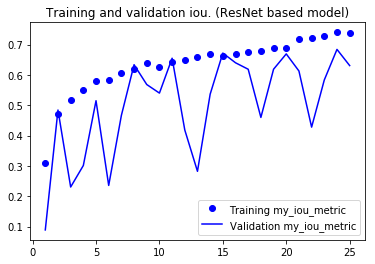

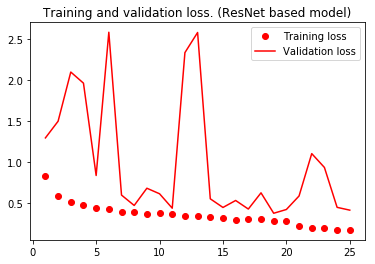

In [24]:
# ResNet based model
iou = history_resnet.history["my_iou_metric"]
val_iou = history_resnet.history["val_my_iou_metric"]
loss = history_resnet.history["loss"]
val_loss = history_resnet.history["val_loss"]

epochs = range(1, len(iou)+1)


# IoUをプロット
plt.plot(epochs, iou, "bo", label="Training my_iou_metric")
plt.plot(epochs, val_iou, "b", label="Validation my_iou_metric")
plt.title("Training and validation iou. (ResNet based model)")
plt.legend()

plt.figure()


# 損失値をプロット
plt.plot(epochs,  loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss. (ResNet based model)")
plt.legend()

plt.show()

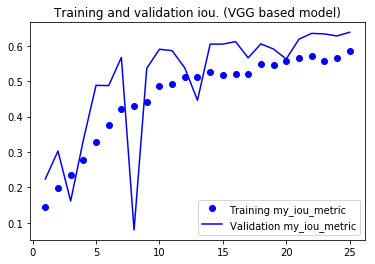

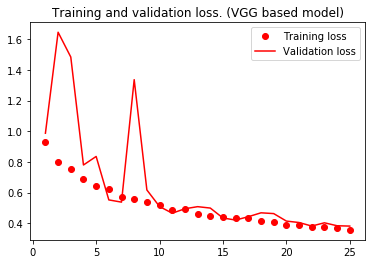

In [27]:
# VGG based model
iou = history_vgg.history["my_iou_metric"]
val_iou = history_vgg.history["val_my_iou_metric"]
loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]

epochs = range(1, len(iou)+1)


# IoUをプロット
plt.plot(epochs, iou, "bo", label="Training my_iou_metric")
plt.plot(epochs, val_iou, "b", label="Validation my_iou_metric")
plt.title("Training and validation iou. (VGG based model)")
plt.legend()

plt.figure()

# 損失値をプロット
plt.plot(epochs,  loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss. (VGG based model)")
plt.legend()

plt.show()

#### 推定結果の比較

- 評価指標であるIoUの最高値をValidation dataで比較した場合、ResNet based model、VGG based model共に最高値は約0.6となった。

- 一方、IoUの推移をValidation dataで比較した場合、VGG based modelのほうが安定している（分散が小さい）ことを踏まえれば、今回はVGG based modelを採用するほうが好ましいと考えられる。

### 結果の可視化

参考として、VGG based modelによるテストデータに対する予測結果をグレイスケールで可視化すると以下の通り。

エポック数が少ないため、地面と塩堆積物と分離境界が不明瞭である。

#### ResNet based model

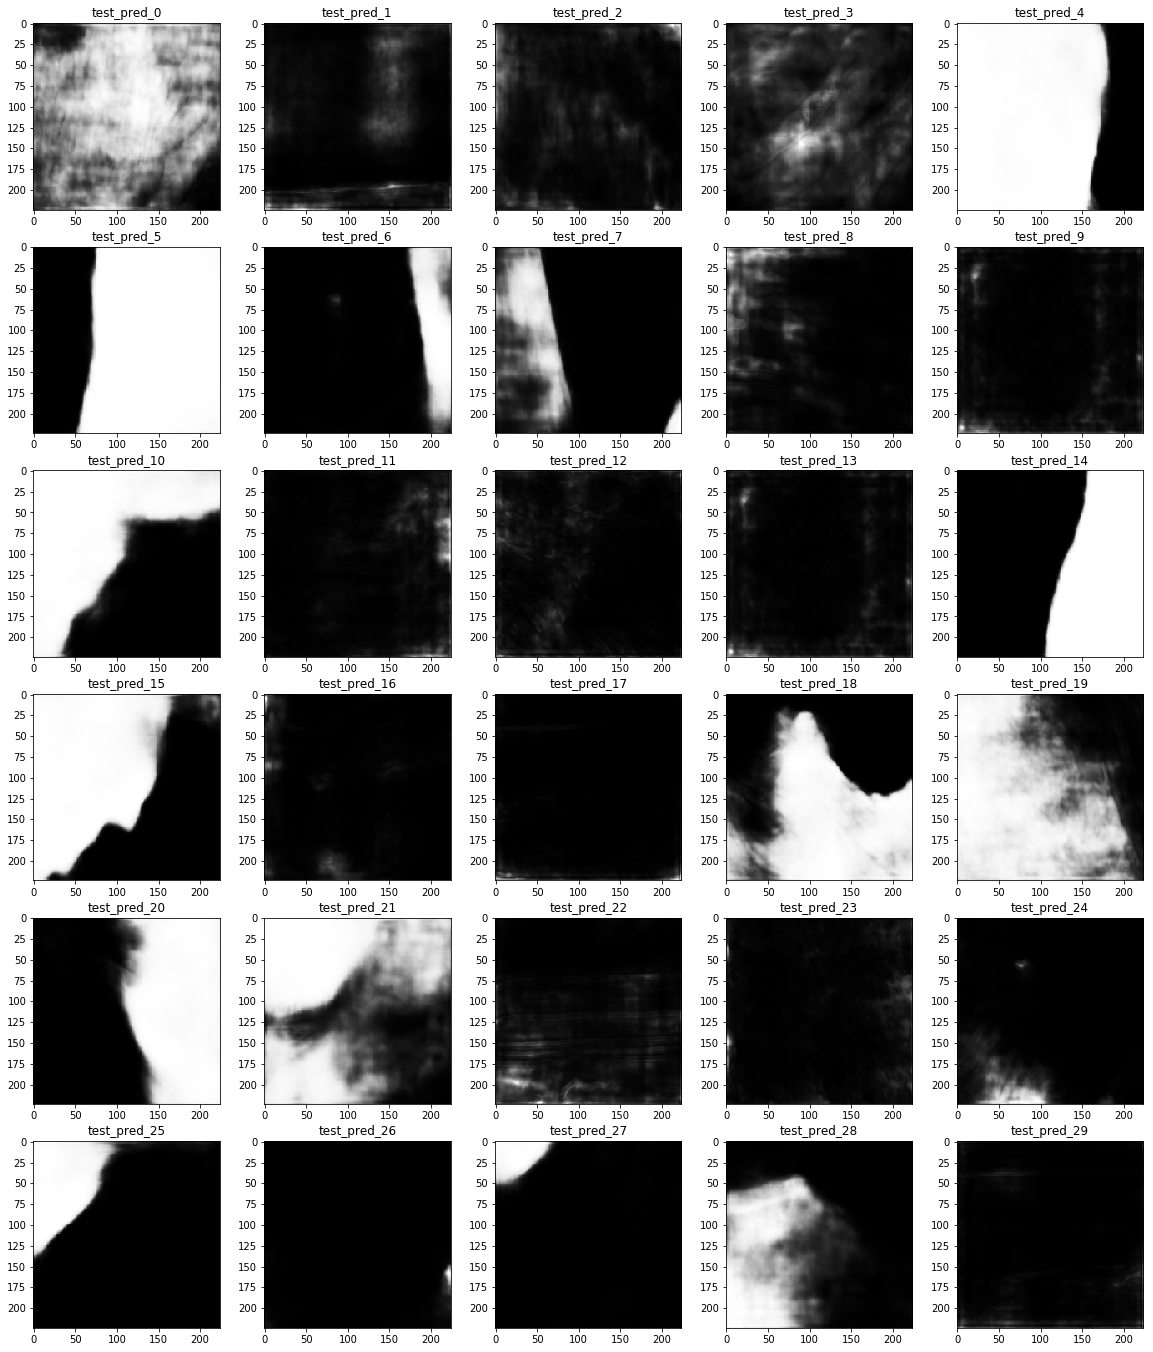

In [25]:
row = 6
column = 5

fig = plt.figure(figsize=(20, 24))

for i in range(row*column):
  ax = fig.add_subplot(row, column, i+1)
  ax.imshow(pred_resnet[i].reshape(224, 224), cmap=plt.cm.gray)
  ax.axis("image")
  ax.set_title("test_pred_{}".format(i))

#### VGG based model

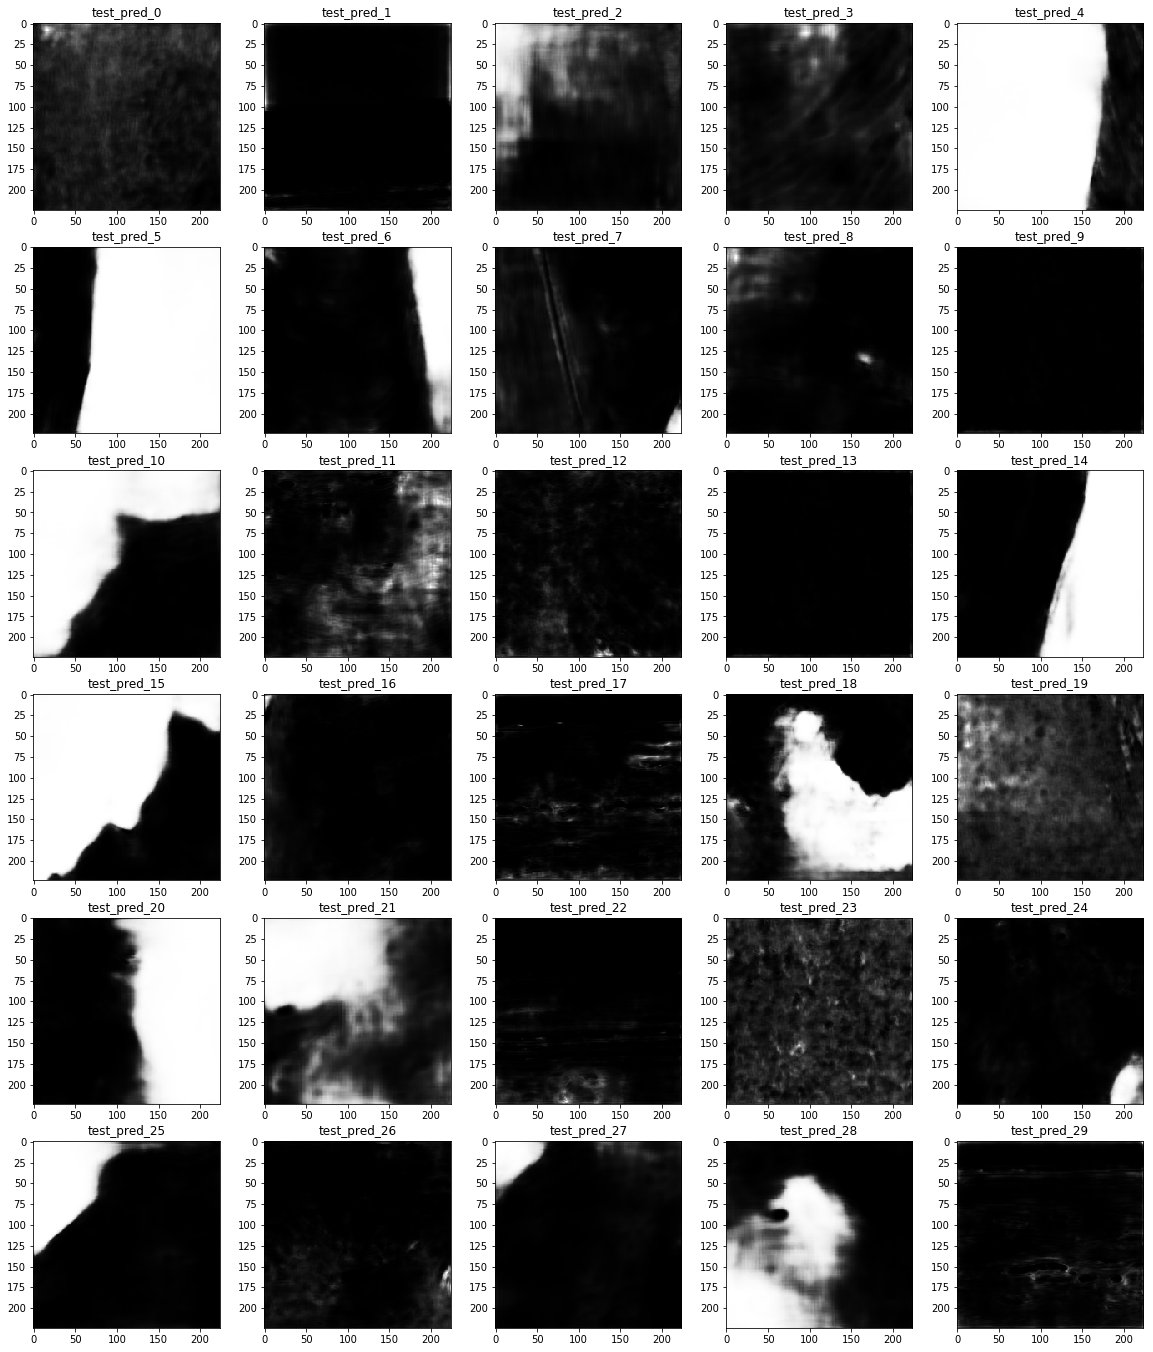

In [28]:
row = 6
column = 5

fig = plt.figure(figsize=(20, 24))

for i in range(row*column):
  ax = fig.add_subplot(row, column, i+1)
  ax.imshow(pred_vgg[i].reshape(224, 224), cmap=plt.cm.gray)
  ax.axis("image")
  ax.set_title("test_pred_{}".format(i))

### Take away

1. ResNetによるU-Net実装をVGGに書き換えることにより、フレームワーク（keras）に対する理解が深まった。今後、自分自身で論文実装する場合に有用だと思われるポイントは以下の通り。
  - レイヤーを所定の順序でaddする場合、関数化すると便利。（今回はupsamplingにおけるdecoderが関数化されていた）
  - kerasに用意されているResNetやVGGなどの既存モデルを応用する場合、アーキテクチャ、レイヤー名称が既定されいる。各レイヤーのoutputのshapeに注目し、参照するレイヤーを間違えないこと。


2. 大量の画像データを扱う際には、余裕を持ったスケジュール調整が重要になる。(GPUを用いても意外に時間がかかる印象)